# Global indicator project - Phoenix, Arizona

## Pandana network accessibility - Public transport stop
This notebook uses [pandana](https://udst.github.io/pandana/network.html) to download street network from OpenStreetMap and then calculate network accessibility to the public transit stop. Stop data is obtained from gtfs data. 


Note: pandana currently only runs on Python 2.

In [12]:
import networkx as nx
import time 
import os
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import geopandas as gpd

import config

#import pandana library
import pandana
from pandana.loaders import osm

import warnings
warnings.filterwarnings(action='once')

ox.config(use_cache=True, log_console=True)
ox.__version__

'0.9'

## Load the metro stop 
GTFS data from transitfeed.com https://transitfeeds.com/p/valley-metro/68

In [3]:
Phx_transp = pd.read_csv('../data/Transport/gtfs_phx/stops.txt')
Phx_metrostops = gpd.GeoDataFrame(Phx_transp)

In [4]:
#define geometry
Phx_metrostops[['stop_lat', 'stop_lon']]  = Phx_metrostops[['stop_lat', 'stop_lon']].astype(float)
Phx_metrostops['geometry'] = Phx_metrostops.apply(lambda row: Point((row['stop_lon'], row['stop_lat'])), axis=1)

In [5]:
Phx_metrostops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,geometry
0,100,16619.0,Bell Rd & 44th St,NaN,33.640488,-111.986041,NaN,NaN,0,NaN,POINT (-111.9860407 33.64048784)
1,1002,15234.0,Alice Av & 66th Dr,NaN,33.563533,-112.200947,NaN,NaN,0,NaN,POINT (-112.2009471 33.56353253)
2,10021,16877.0,3rd St & Taylor St,NaN,33.453085,-112.070037,NaN,NaN,0,NaN,POINT (-112.070037 33.45308499999999)
3,1003,13532.0,Atlanta Av & 11th Av,NaN,33.400036,-112.085804,NaN,NaN,0,NaN,POINT (-112.0858039 33.4000364)
4,1004,14926.0,Baseline Rd & 19th Av,NaN,33.377644,-112.098529,NaN,NaN,0,NaN,POINT (-112.0985289 33.377644)


## Load the OSM streetnetwork graph using OSMnx

In [23]:
place = 'Phoenix, Arizona, USA'

In [ ]:
Phx_osm_all = ox.load_graphml('{studyregion}_all{suffix}.graphml'.format(studyregion = place, suffix = config.time), folder = config.OSM_data_loc)
Phx_osm_all_gdfs = ox.graph_to_gdfs(Phx_osm_all, nodes=False, edges=True, fill_edge_geometry=True)

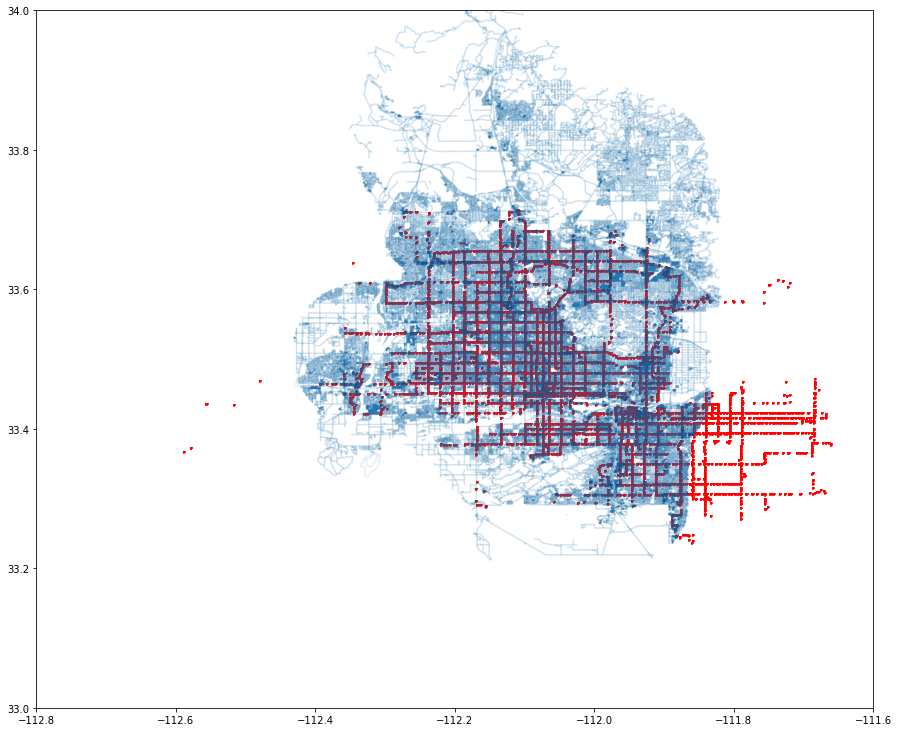

In [26]:
#plot metro stops with OSM all street network
fig, ax = plt.subplots(figsize=(15, 15))
ax = Phx_osm_all_gdfs.plot(ax=ax, alpha=0.1)
ax = Phx_metrostops.plot(ax=ax, color='red', marker='+', markersize=9)
ax.set_ylim((33,34))
ax.set_xlim((-112.8, -111.6))
#ax.set_axis_off()
#fig.suptitle('Meto stops', fontsize=14, fontweight='bold')
#fig.text(0.1, 0, 'Note: OSM street network')
plt.show()

## Load the OSM streetnetwork using Pandana

In [6]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
distance = 1000
num_pois = 10

# bounding box as a list of llcrnrlat, llcrnrlng, urcrnrlat, urcrnrlng
bbox = [33.29, -112.32, 33.92, -111.93] #lat-long bounding box for Phx

In [25]:
# configure filenames to save/load POI and network datasets
net_filename = '../data/OSM/{}_network.h5'.format(place[0:4])

In [26]:
start_time = time.time()
if os.path.isfile(net_filename):
    # if a street network file already exists, just load the dataset from that
    network = pandana.network.Network.from_hdf5(net_filename)
    method = 'loaded from HDF5'
else:
    # otherwise, query the OSM API for the street network within the specified bounding box
    network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
    method = 'downloaded from OSM'
    
    # identify nodes that are connected to fewer than some threshold of other nodes within a given distance
    lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')
    network.save_hdf5(net_filename, rm_nodes=lcn) #remove low-connectivity nodes and save to h5
    
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

Network with 205,891 nodes loaded from HDF5 in 28.77 secs


## Calculate accessibility to the amenity we retrieved

In [14]:
# precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [15]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
network.set_pois(category='all', maxdist=distance, maxitems=num_pois, x_col=Phx_metrostops['stop_lon'], y_col=Phx_metrostops['stop_lat'])

In [16]:
# searches for the n nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head()

207,233 nodes


,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
41190548,182.214005,211.658005,283.483002,310.792999,583.523987,608.900024,664.755981,686.997009,726.752991,757.096985
41190554,327.812012,341.382996,363.837006,465.105988,580.231018,604.931030,634.656006,634.656006,636.086975,661.064026
41190566,285.286011,375.217987,397.273010,458.160004,677.966980,677.966980,736.554016,736.554016,838.721008,875.729004
41190568,471.039001,492.765991,492.765991,560.971008,583.026001,643.913025,723.927002,724.231995,757.234985,802.687012
41190571,282.289001,282.289001,513.450012,513.755005,546.757996,592.210022,622.255005,635.596008,681.515991,771.447998


## Plot accessibility from each node to public transport stop

In [18]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

Text(0.5,1,'Walking distance (m) to nearest transit stops (gtfs) around Phoenix')

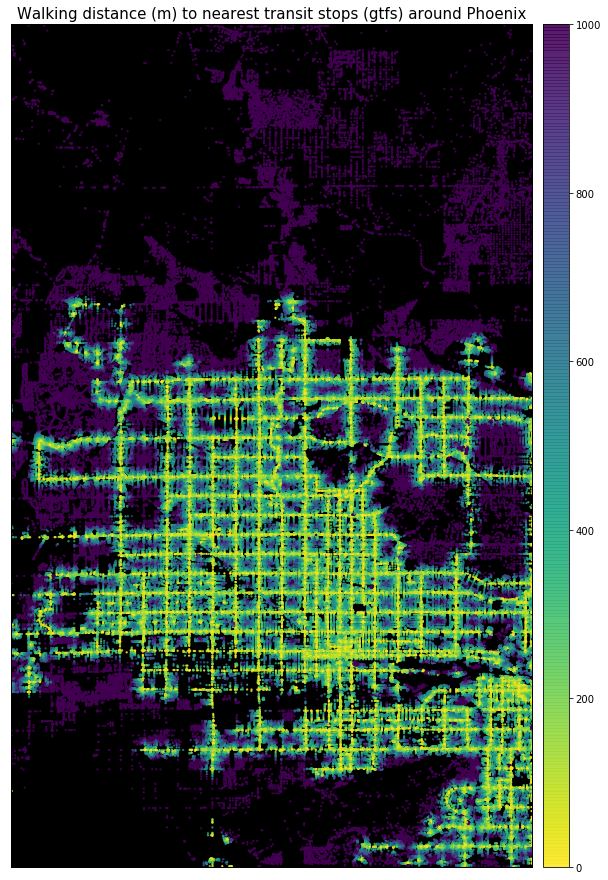

In [20]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest transit stops (gtfs) around Phoenix', fontsize=15)
#fig.savefig('images/accessibility-shop-phx.png', dpi=200, bbox_inches='tight')